#  Perceptron & SVM sur des caracteres manuscrits

Ce notebook utilise un dataset d'images stocké dans le dossier `curated_data/` pour :
- charger et préparer les images (grayscale, 32×32),
- entraîner un **MLP maison** (perceptron multi-couches),
- entraîner un **SVM** (baseline scikit-learn),
- comparer leurs performances,
- faire une petite démo de **reconnaissance de mot** lettre par lettre.

##  Imports & configuration

In [1]:

import os
from os.path import join

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

#CURATED_DIR = "curated_data"  # trop lourd a push ou deplacer
IMG_SIZE = (32, 32)           # taille des images


##  Chargement du dataset `curated_data/`

In [2]:
import os
from os.path import join
import cv2
import numpy as np

class BDD:
    """
    Parcourt récursivement 'root_dir' et :
    1. Trouve le dossier qui contient directement les sous-dossiers 33..126
    2. Charge toutes les images dans ces sous-dossiers (niveaux de gris, redimensionnées)
    """

    def __init__(self, root_dir="curated_data", img_size=(32, 32)):
        self.root_dir = root_dir
        self.img_size = img_size
        self.X = None
        self.Y = None
        self.unique_labels_raw = None
        self.label_map = None
        self.label_map_inv = None

    def _find_base_dir(self):
        """
        Cherche un dossier qui contient directement des sous-dossiers
        dont les noms sont numériques (33, 34, ..., 126).
        Ignore __MACOSX.
        """
        print(f"\ Recherche du dossier de base sous '{self.root_dir}'...")
        for root, dirs, files in os.walk(self.root_dir):
            # on ignore les dossiers macOS
            dirs[:] = [d for d in dirs if not d.startswith("__MACOSX")]

            # si ce dossier a des sous-dossiers numériques → c'est notre base
            numeric_subdirs = []
            for d in dirs:
                try:
                    int(d)
                    numeric_subdirs.append(d)
                except ValueError:
                    continue

            if numeric_subdirs:
                print(f" Dossier de base trouvé : {root}")
                print(f"   Sous-dossiers numériques détectés (exemple) : {numeric_subdirs[:5]}")
                return root

        raise FileNotFoundError(
            f"Aucun dossier contenant des sous-dossiers numériques (33..126) trouvé sous '{self.root_dir}'"
        )

    def verify_archive_structure(self):
        """
        À partir du dossier de base, récupère tous les fichiers images
        dans les sous-dossiers numériques.
        """
        base_dir = self._find_base_dir()
        found_files = []

        for root, dirs, files in os.walk(base_dir):
            dirs[:] = [d for d in dirs if not d.startswith("__MACOSX")]
            for file in files:
                if not file.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue
                full_path = join(root, file)
                parent = os.path.basename(os.path.dirname(full_path))
                try:
                    int(parent)  # vérifie que le dossier parent est bien un nombre
                    found_files.append(full_path)
                except ValueError:
                    continue

        print(f" {len(found_files)} image(s) trouvée(s) dans les sous-dossiers numériques.")
        if found_files:
            print("   Exemple de chemin :", found_files[0])
        return found_files

    def load_data(self):
        X, y = [], []
        found_files = self.verify_archive_structure()

        if not found_files:
            raise FileNotFoundError(
                "Aucune image trouvée dans les dossiers numériques (33..126)."
            )

        for img_path in found_files:
            try:
                label_dir = os.path.basename(os.path.dirname(img_path))
                try:
                    char_code = int(label_dir)  # 33..126
                except ValueError:
                    continue

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, self.img_size)
                X.append(img)
                y.append(char_code)
            except Exception as e:
                print(f"⚠️ Erreur sur {img_path}: {e}")

        self.X = np.array(X)
        self.Y = np.array(y)
        print(" Dimensions X:", self.X.shape, "| Y:", self.Y.shape)
        return self.X, self.Y

    def sortie(self, test_ratio=0.2, seed=42):
        """
        Retourne : x_train, y_train, x_test, y_test
        avec labels remappés sur 0..K-1.
        """
        self.load_data()
        n = len(self.X)
        indices = np.arange(n)
        rng = np.random.default_rng(seed)
        rng.shuffle(indices)

        x_shuffled = self.X[indices]
        y_shuffled = self.Y[indices]

        # Remappage 33..126 → 0..K-1
        unique_labels = sorted(np.unique(y_shuffled))
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        y_mapped = np.array([label_map[y] for y in y_shuffled])

        split_idx = int((1.0 - test_ratio) * n)
        x_train = x_shuffled[:split_idx]
        y_train = y_mapped[:split_idx]
        x_test  = x_shuffled[split_idx:]
        y_test  = y_mapped[split_idx:]

        # On garde les correspondances pour la démo
        self.unique_labels_raw = unique_labels          # ex: [33, 34, ..., 126]
        self.label_map = label_map                      # brut -> index
        self.label_map_inv = {v: k for k, v in label_map.items()}  # index -> brut

        print(f" Split: {len(x_train)} train / {len(x_test)} test | {len(unique_labels)} classes")
        return x_train, y_train, x_test, y_test

    def get_unique_labels(self):
        if self.Y is None:
            self.load_data()
        return sorted(np.unique(self.Y))


def prepare_dataset(X, Y):
   
    X = X.astype(np.float32) / 255.0
    return [(int(Y[i]), X[i].flatten().reshape(-1, 1)) for i in range(len(X))]


<>:28: SyntaxWarning: invalid escape sequence '\ '
<>:28: SyntaxWarning: invalid escape sequence '\ '
C:\Users\User\AppData\Local\Temp\ipykernel_19044\2429767401.py:28: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Recherche du dossier de base sous '{self.root_dir}'...")


##  Modèle MLP (perceptron multi-couches)

In [ ]:
class MultiClassPerceptron:
    def __init__(self, nb_classes, nb_neurones, iterations, taux, activation, batch_size=32):
        self.taux = taux
        self.nb_classes = nb_classes
        self.iterations = iterations  # = nombre d'époques
        self.nb_couches = len(nb_neurones)
        self.nb_neurones = nb_neurones
        self.activation = activation  # "relu" ou "sigmoid"
        self.batch_size = batch_size

        self.poids = {}
        self.taille_entree = IMG_SIZE[0] * IMG_SIZE[1]

        # Initialisation Xavier/He simple
        self.poids[0] = np.random.randn(nb_neurones[0], self.taille_entree + 1) * np.sqrt(1 / self.taille_entree)
        for i in range(1, self.nb_couches):
            self.poids[i] = np.random.randn(nb_neurones[i], nb_neurones[i - 1] + 1) * np.sqrt(1 / nb_neurones[i - 1])
        self.poids[self.nb_couches] = np.random.randn(nb_classes, nb_neurones[-1] + 1) * np.sqrt(1 / nb_neurones[-1])

    def ajout_biais(self, X):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        ones = np.ones((1, X.shape[1]), dtype=X.dtype)
        return np.vstack([X, ones])

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_prime(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        # x : (nb_classes, batch)
        x = x - np.max(x, axis=0, keepdims=True)
        exps = np.exp(x)
        return exps / np.sum(exps, axis=0, keepdims=True)

    def forward(self, X):
        """
        X : (input_dim, batch_size)
        Retourne:
            Zs : liste des pré-activations par couche
            As : liste des activations (avec biais pour les couches cachées, sans biais pour la sortie)
        """
        if X.ndim == 1:
            X = X.reshape(-1, 1)

        Zs = []
        As = []

        A = self.ajout_biais(X)  # (input_dim + 1, B)
        As.append(A)

        # Couches cachées
        for i in range(self.nb_couches):
            Z = self.poids[i] @ A  # (h_i, B)
            Zs.append(Z)

            if self.activation == "relu":
                H = self.relu(Z)
            else:
                H = self.sigmoid(Z)

            A = self.ajout_biais(H)  # (h_i + 1, B)
            As.append(A)

        Z = self.poids[self.nb_couches] @ A  # (nb_classes, B)
        Zs.append(Z)
        Y_hat = self.softmax(Z)  # (nb_classes, B)
        As.append(Y_hat)

        return Zs, As

    def backward(self, Y_true, Zs, As):
    
        B = Y_true.shape[1]
        grads = [None] * (self.nb_couches + 1)

        # Sortie : softmax + cross-entropy → delta = Y_hat - Y_true
        delta = As[-1] - Y_true  # (nb_classes, B)
        grads[self.nb_couches] = (delta @ As[-2].T) / B  # (nb_classes, h_last+1)

        # Couches cachées (backprop)
        for layer in range(self.nb_couches - 1, -1, -1):
            W_next = self.poids[layer + 1][:, :-1]  # On enlève la colonne des biais
            Z = Zs[layer]  # (h_l, B)

            if self.activation == "relu":
                prime = self.relu_prime(Z)
            else:
                # H_l = activation(Z_l) = As[layer+1] sans la dernière ligne de biais
                H = As[layer + 1][:-1, :]
                prime = H * (1 - H)

            delta = (W_next.T @ delta) * prime  # (h_l, B)
            grads[layer] = (delta @ As[layer].T) / B  # (h_l, prev+1)

        return grads

    def entrainer(self, data):
  
        n = len(data)
        for epoch in range(self.iterations):
            indices = np.random.permutation(n)

            for start in range(0, n, self.batch_size):
                end = min(start + self.batch_size, n)
                batch_idx = indices[start:end]

                batch_labels = [data[k][0] for k in batch_idx]
                batch_pixels = [data[k][1] for k in batch_idx]  # chaque élément : (input_dim, 1)

                X_batch = np.hstack(batch_pixels)

                B = len(batch_labels)
                Y_true = np.zeros((self.nb_classes, B), dtype=np.float32)
                Y_true[batch_labels, np.arange(B)] = 1.0

                # forward + backward + mise à jour
                Zs, As = self.forward(X_batch)
                grads = self.backward(Y_true, Zs, As)

                for i in range(self.nb_couches + 1):
                    self.poids[i] -= self.taux * grads[i]

            print(f"Époque {epoch + 1}/{self.iterations} terminée")

    def tester(self, pixels):

        if pixels.ndim == 1:
            pixels = pixels.reshape(-1, 1)
        _, As = self.forward(pixels)
        return int(np.argmax(As[-1], axis=0)[0])


##  Chargement des données et préparation

In [4]:
bdd = BDD(
    root_dir=r"C:\Users\User\PycharmProjects\pythonProject6\.venv\curated_data",
    img_size=(32, 32)
)
x_train, y_train, x_test, y_test = bdd.sortie()




pixel_train = prepare_dataset(x_train, y_train)
pixel_test = prepare_dataset(x_test, y_test)

labels_uniques = bdd.get_unique_labels()
nb_classes = len(labels_uniques)
print("Nombre de classes brutes :", nb_classes)
print(f"Nombre d'images de train : {len(pixel_train)}")
print(f"Nombre d'images de test  : {len(pixel_test)}")


\ Recherche du dossier de base sous 'C:\Users\User\PycharmProjects\pythonProject6\.venv\curated_data'...
 Dossier de base trouvé : C:\Users\User\PycharmProjects\pythonProject6\.venv\curated_data\curated_data\curated
   Sous-dossiers numériques détectés (exemple) : ['100', '101', '102', '103', '104']
 62382 image(s) trouvée(s) dans les sous-dossiers numériques.
   Exemple de chemin : C:\Users\User\PycharmProjects\pythonProject6\.venv\curated_data\curated_data\curated\100\10062.png
 Dimensions X: (62382, 32, 32) | Y: (62382,)
 Split: 49905 train / 12477 test | 93 classes
Nombre de classes brutes : 93
Nombre d'images de train : 49905
Nombre d'images de test  : 12477


##  Entraînement du MLP sur `curated_data`

In [5]:
nb_neurones = [1024, 512, 256]
iterations = 5
taux = 0.01

mlp = MultiClassPerceptron(
    nb_classes,
    nb_neurones,
    iterations,
    taux,
    activation="relu",
    batch_size=32  # par exemple
)

mlp.entrainer(pixel_train)


Époque 1/5 terminée
Époque 2/5 terminée
Époque 3/5 terminée
Époque 4/5 terminée
Époque 5/5 terminée


##  Évaluation du MLP

In [6]:

correct_predictions = sum(1 for label, pixels in pixel_test if mlp.tester(pixels) == label)
accuracy_mlp = correct_predictions / len(pixel_test) * 100
print(f"MLP - Taux de réussite : {accuracy_mlp:.2f}%")


MLP - Taux de réussite : 60.25%


## ⚔️ Baseline SVM (scikit-learn)

SVM - Taux de réussite : 74.99%
Temps d'entraînement SVM : 1116.24 s


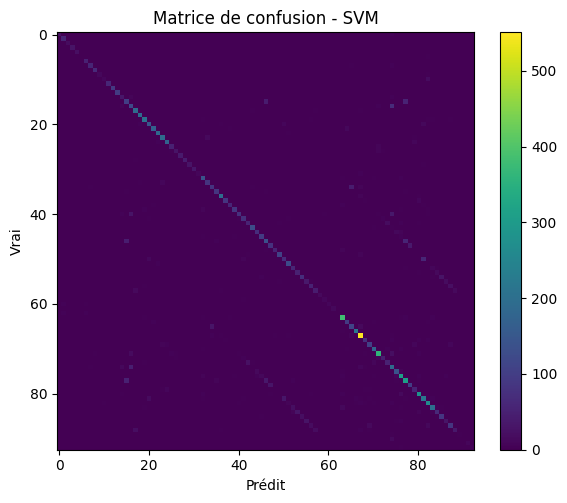

In [7]:

X_train_svm = x_train.reshape(len(x_train), -1).astype(np.float32) / 255.0
X_test_svm  = x_test.reshape(len(x_test), -1).astype(np.float32) / 255.0

y_train_svm = y_train
y_test_svm  = y_test

svm = SVC(kernel="rbf", C=5, gamma=0.01)

import time
t0 = time.time()
svm.fit(X_train_svm, y_train_svm)
t1 = time.time()

y_pred_svm = svm.predict(X_test_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm) * 100

print(f"SVM - Taux de réussite : {accuracy_svm:.2f}%")
print(f"Temps d'entraînement SVM : {t1 - t0:.2f} s")

cm_svm = confusion_matrix(y_test_svm, y_pred_svm)

plt.figure(figsize=(6, 5))
plt.imshow(cm_svm, interpolation="nearest")
plt.title("Matrice de confusion - SVM")
plt.colorbar()
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.tight_layout()
plt.show()


##  Démo : reconnaissance d'un mot lettre par lettre 

Début de la reconnaissance lettre par lettre :
Lettre cible: 'B' → Prédiction MLP: 'B' Réussite


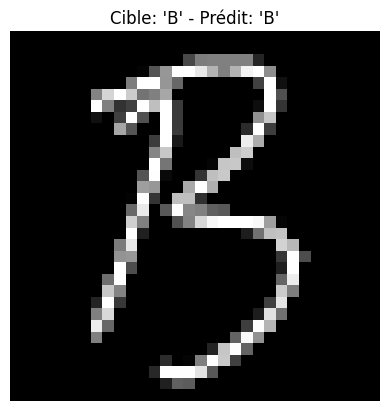

Lettre cible: 'O' → Prédiction MLP: '0' Flop


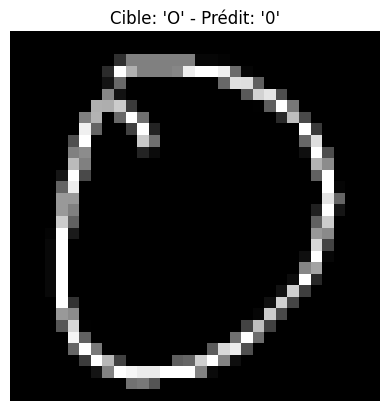

Lettre cible: 'N' → Prédiction MLP: 'N' Réussite


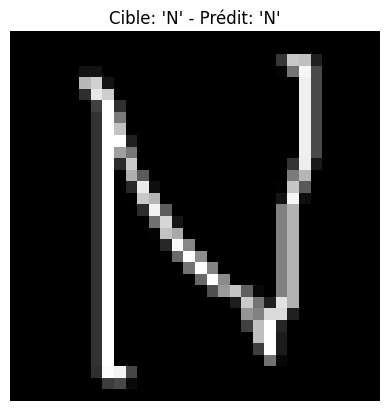

Lettre cible: 'J' → Prédiction MLP: '=' Flop


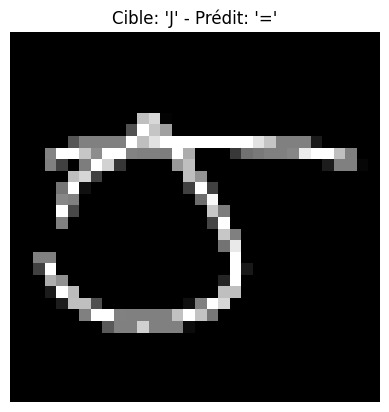

Lettre cible: 'O' → Prédiction MLP: '0' Flop


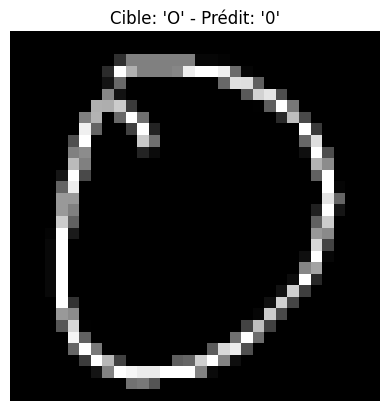

Lettre cible: 'U' → Prédiction MLP: 'U' Réussite


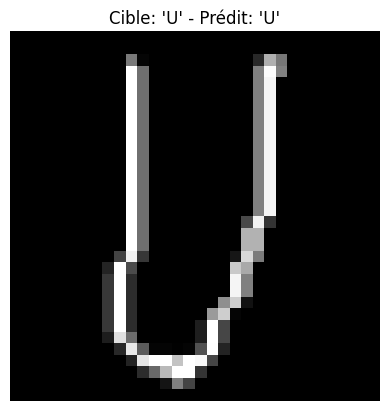

Lettre cible: 'R' → Prédiction MLP: 't' Flop


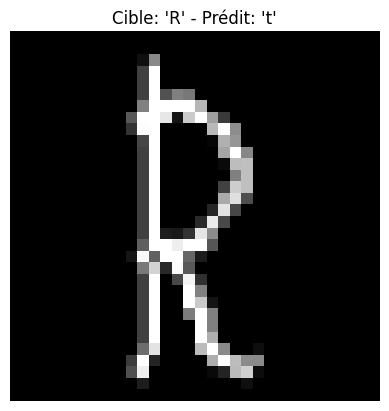

In [12]:

unique_labels = bdd.unique_labels_raw
inverse_map = {i: unique_labels[i] for i in range(len(unique_labels))}

def trouver_image_de_lettre(le_char, x_data, y_data):
    code_ascii = ord(le_char)
    if code_ascii in unique_labels:
        idx_label = unique_labels.index(code_ascii)
        for i in range(len(y_data)):
            if y_data[i] == idx_label:
                return x_data[i].reshape(-1, 1) / 255.0
    return None

mot = "BONJOUR"  
# mot = input("Entrez une chaîne de caractères (Ex: BONJOUR!) : ")

print("Début de la reconnaissance lettre par lettre :")
for lettre in mot:
    pixels = trouver_image_de_lettre(lettre, x_test, y_test)
    if pixels is not None:
        prediction = mlp.tester(pixels)
        lettre_predite = chr(inverse_map[prediction])
        print(
            f"Lettre cible: '{lettre}' → Prédiction MLP: '{lettre_predite}' "
            f"{'Réussite' if lettre == lettre_predite else 'Flop'}"
        )
        plt.figure()
        plt.imshow(pixels.reshape(IMG_SIZE), cmap="gray")
        plt.title(f"Cible: '{lettre}' - Prédit: '{lettre_predite}'")
        plt.axis("off")
        plt.show()
    else:
        print(f"Lettre '{lettre}' non trouvée dans les données de test ")
